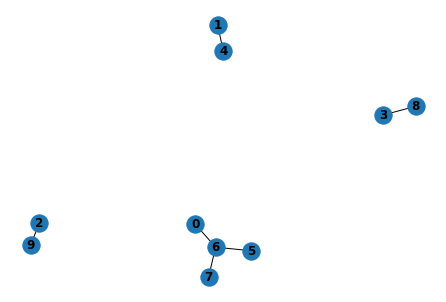

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


G = nx.erdos_renyi_graph(10, 0.15)
nx.draw(G, with_labels=True, font_weight='bold')

In [43]:
edges = list(G.edges)

In [44]:
#edges = [ (edges_mat.nonzero()[0][t],edges_mat.nonzero()[1][t]) for t in range(len(edges_mat.nonzero()[0])) ]
edges

[(0, 6), (1, 4), (2, 9), (3, 8), (5, 6), (6, 7)]

In [6]:
import igraph as ig

In [45]:
g = ig.Graph()

#iterate through edges and put all the vertices in a list
vertex = []
for edge in edges:
    vertex.extend(edge)

g.add_vertices( list( set(vertex))) # add a list of unique vertices to the graph
g.add_edges(edges) # add the edges to the graph. 

print(g)

IGRAPH UN-- 10 6 --
+ attr: name (v)
+ edges (vertex names):
0--6, 1--4, 2--9, 3--8, 5--6, 6--7


In [46]:
weights = np.random.rand(len(edges))
weights

array([0.77696072, 0.92765801, 0.10534237, 0.62491814, 0.68793101,
       0.03916834])

In [47]:
dend = g.community_fastgreedy(weights=weights)

In [48]:
dend.format()

'(7,(2,(4,1)9)13)14;'

In [49]:
ig.summary(dend)

Dendrogram, 9 elements, 6 merges


In [71]:
optimal_count = dend.optimal_count_ratio(0.99)
optimal_count

5

In [72]:
clus = dend.as_clustering(optimal_count)

In [108]:
clus.summary()

'Clustering with 10 elements and 5 clusters'

In [109]:
clus.modularity

0.6409250082296326

In [73]:
memberships = clus.membership
memberships

[0, 1, 2, 3, 1, 0, 0, 4, 3, 2]

In [55]:
for i in range(len(memberships)):
    G.nodes[i]['group'] = memberships[i]

In [67]:
G.nodes.data()

NodeDataView({0: {'group': 0}, 1: {'group': 1}, 2: {'group': 2}, 3: {'group': 3}, 4: {'group': 1}, 5: {'group': 0}, 6: {'group': 0}, 7: {'group': 4}, 8: {'group': 3}, 9: {'group': 5}})

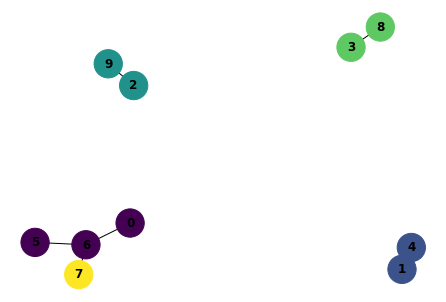

In [74]:
pos = nx.spring_layout(G, iterations=2)
nx.draw(G, with_labels=True, font_weight='bold', node_color=memberships, node_size=800)
plt.show()

In [75]:
# TODO: write a func: given weighted adjacency matrix and modularity ratio -> return cluster memberships

In [213]:
def edges_to_iGraph(edges_mat):

    edges = [ (edges_mat.nonzero()[0][t],edges_mat.nonzero()[1][t]) for t in range(len(edges_mat.nonzero()[0])) ]

    # iGraph expects vertex names to be 0,1,2,..., so we need a mapping 
    vertices = set()
    for e in edges: vertices |= set(e)
    vertex_mapping = list(vertices)
    # vertex_mapping.index(7) # bu bug heralde
    # update edges according to new mapping
    edges = [(vertex_mapping.index(e[0]), vertex_mapping.index(e[1])) for e in edges]
        
    g = ig.Graph()

    g.add_vertices( vertex_mapping ) # add a list of unique vertices to the graph
    g.add_edges( edges ) # add the edges to the graph. 
    
    return g, vertex_mapping

def memberships_to_cluster_list(memberships):
    memberships = np.asarray(memberships)

    clusters_list = []
    for c in np.unique(memberships):
        clusters_list.append(np.nonzero(memberships == c)[0].tolist())
    return clusters_list

def cluster_adj_mat(edges_mat, q_thr = 0.8):

    weights = edges_mat[edges_mat.nonzero()] # edge weights

    g, vertex_mapping = edges_to_iGraph(edges_mat)

    dend = g.community_fastgreedy(weights=weights) 

    # func. below is added from: ...envs/tez/lib/python3.6/site-packages/igraph/clustering.py
    optimal_count = dend.optimal_count_ratio(ratio=q_thr)

    clus = dend.as_clustering(optimal_count)

    memberships = clus.membership

    modularity = clus.modularity

    clusters_list = memberships_to_cluster_list(memberships)

    return clusters_list, memberships, modularity

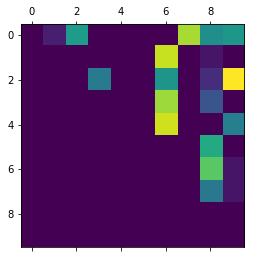

In [255]:
n = 10
edges_mat = np.random.uniform(-2,1,(n,n))
edges_mat = np.triu(edges_mat, k=1)
edges_mat = np.maximum(edges_mat,0)
plt.matshow(edges_mat)

In [256]:
def find_single_nodes(edges_mat):
    # find isolated nodes in the graph
    assert edges_mat.shape[0] == edges_mat.shape[1] # i.e. square
    nodes_to_delete = []
    for i in range(edges_mat.shape[0]):
        if sum(edges_mat[i,:]) == 0 and sum(edges_mat[:,i]) == 0:
            nodes_to_delete.append(i)
    return nodes_to_delete

def remove_single_nodes(edges_mat, nodes_to_delete):
    # delete nodes that dont have any connection    
    edges_mat = np.delete(edges_mat, np.asarray(nodes_to_delete), axis=0 )
    edges_mat = np.delete(edges_mat, np.asarray(nodes_to_delete), axis=1 )

    return edges_mat

nodes_to_delete = find_single_nodes(edges_mat)
if len(nodes_to_delete) > 0: 
    print('{} nodes are deleted..'.format(len(nodes_to_delete)))
    edges_mat = remove_single_nodes(edges_mat, nodes_to_delete)

(-0.8104434592709596,
 0.7393980201107427,
 -1.1585719091327502,
 0.9915597412675912)

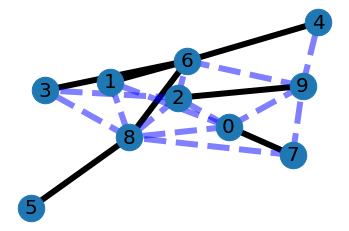

In [262]:
edges = [ (edges_mat.nonzero()[0][t],edges_mat.nonzero()[1][t]) for t in range(len(edges_mat.nonzero()[0])) ]
weights = edges_mat[edges_mat.nonzero()] # edge weights
edges = [(e[0],e[1], weights[i]) for i,e in enumerate(edges)]

G = nx.Graph()
# add edges from txt 
G.add_weighted_edges_from(edges)
pos = nx.spring_layout(G, weight='weights')
#nx.draw(G, with_labels=True, pos=pos, font_weight='bold')

elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.5]

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=6)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=6, alpha=0.5, edge_color='b', style='dashed')

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')

In [258]:
clusters_list, memberships, modularity = cluster_adj_mat(edges_mat, q_thr = 0.8)

In [259]:
clusters_list

[[0, 7], [1, 3, 4, 6], [2, 9], [5, 8]]

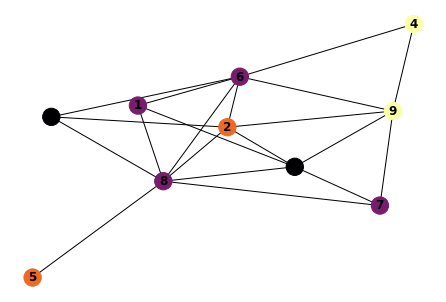

In [263]:
nx.draw(G, with_labels=True, pos=pos , font_weight='bold', node_color=memberships, cmap='inferno')
plt.show()

In [182]:
edges_mat[10:,10:]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.65366946, 0.20083314],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99626032, 0.        , 0.92618097, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.26937838, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.98451564],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.41011977, 0.22527159],
       [0.        , 0.        , 0.       

In [183]:
clusters_list

[[0, 11],
 [1],
 [2, 9],
 [3, 6],
 [4],
 [5, 7, 8, 14],
 [10],
 [12, 16, 17, 18],
 [13],
 [15, 19]]

In [185]:
memberships[13:]

[8, 5, 9, 7, 7, 7, 9]